## Do composite of El Nino/La Nina events for CONUS snowfall anom.  

## This is for after peak (DJF, JFM onwards)

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cpf
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
import matplotlib.patches as mpatches

import cartopy.feature as cfeature

from platform import python_version
print(python_version())

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

3.13.2


## Load in ERA5 snowfall and subset it by region
### make the area-average for the subregion
### write out as .csv

swe.mean.44-120.5.csv
Dataset saved to CSV successfully!
swe.mean.44-117.5.csv
Dataset saved to CSV successfully!
swe.mean.44-115.5.csv
Dataset saved to CSV successfully!
swe.mean.44-111.5.csv
Dataset saved to CSV successfully!
swe.mean.44-110.5.csv
Dataset saved to CSV successfully!
swe.mean.42-120.5.csv
Dataset saved to CSV successfully!
swe.mean.42-117.5.csv
Dataset saved to CSV successfully!
swe.mean.42-115.5.csv
Dataset saved to CSV successfully!
swe.mean.42-111.5.csv
Dataset saved to CSV successfully!
swe.mean.42-110.5.csv
Dataset saved to CSV successfully!


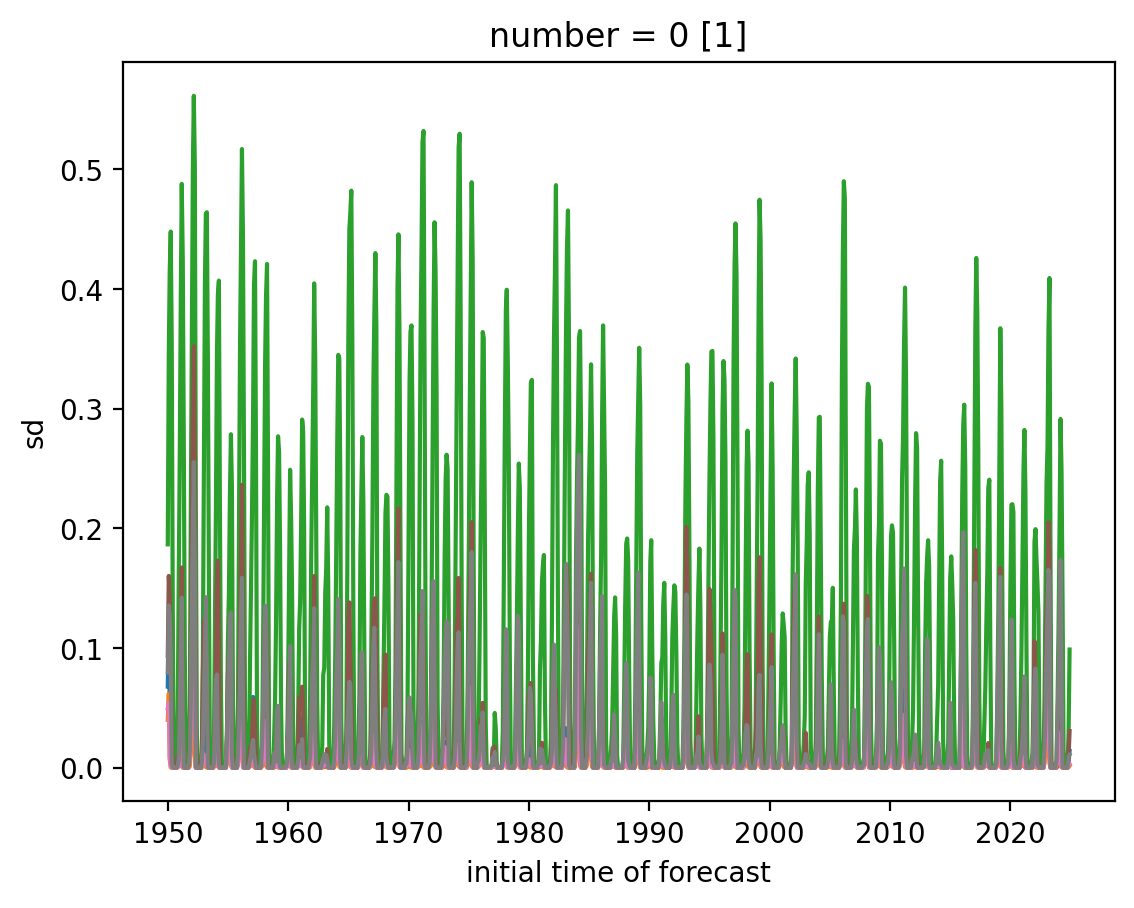

In [2]:
swe = xr.open_dataset('swe.data.ERA5.nc.nc')

### Uncomment this block if you end up in France again
# swe.longitude.attrs['units'] = 'degrees west'
# Temp = swe.longitude.values
# Temp = ((360-Temp))
# Temp = Temp[::-1]
# swe = swe.assign_coords(longitude=Temp)
# swe.longitude

northlat=[44, 42] #can adjust these
westlon=[-120.5, -117.5, -115.5, -111.5, -110.5]

for lat in northlat:
    southlat = lat - 1.0
    for lon in westlon:
        eastlon = lon + 1.0

        reg1 = swe.sel(latitude=slice(lat,southlat), longitude=slice(lon,eastlon))
        reg1 = reg1.mean(dim='latitude').mean(dim='longitude')
        reg1.sd.plot()

        fn = 'swe.mean.'+str(lat)+str(lon)+'.csv'
        print(fn)
        df = reg1.to_dataframe()
        df.to_csv("reg1_output.csv")

        print("Dataset saved to CSV successfully!")

## Read in PNA index

/tmp/ipykernel_3399052/1844869614.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pna = pd.read_csv('PNA.data.txt', header=None, delim_whitespace=True)


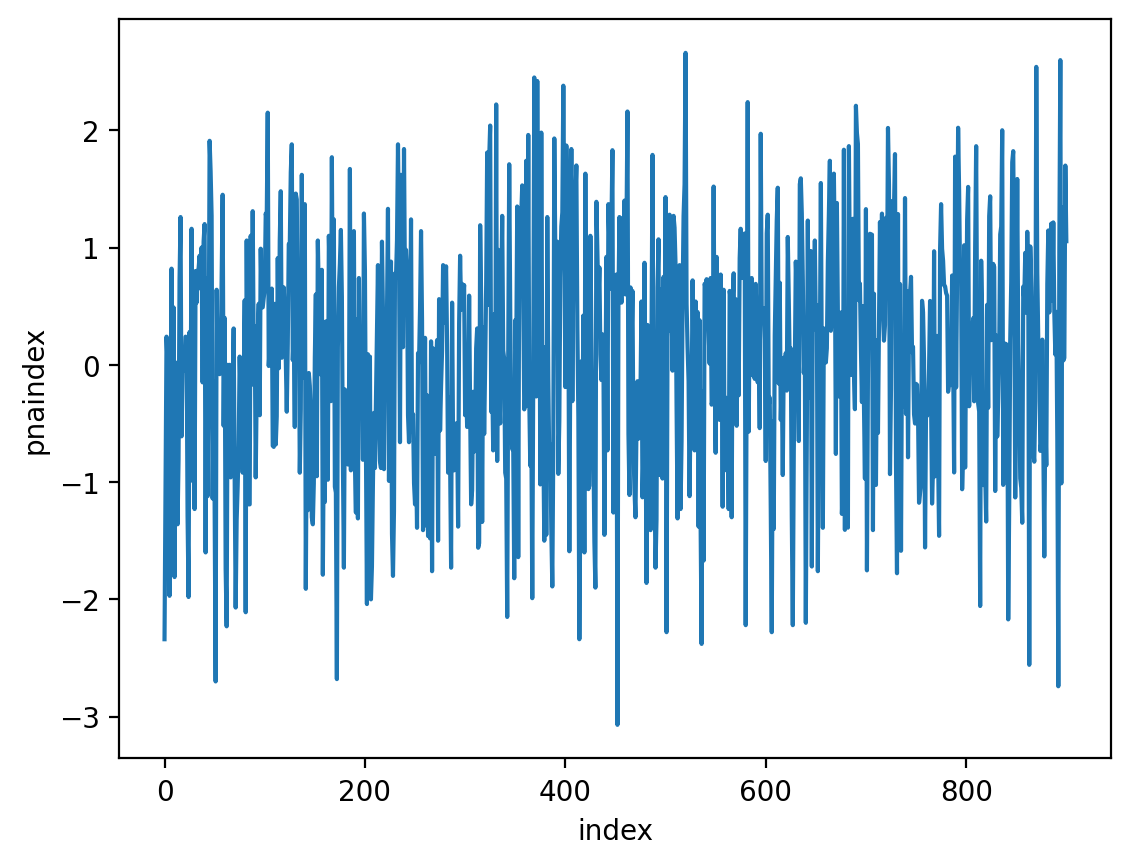

In [3]:
pna = pd.read_csv('PNA.data.txt', header=None, delim_whitespace=True)
start_date = '1950-01-01'
selected_column = pna[2]
selected_column
data_array = selected_column.to_xarray()
pna = xr.Dataset({'pnaindex':data_array})
pna['Time'] = pd.date_range(start=start_date, periods=len(selected_column), freq='MS')
pna.pnaindex.plot()

## Read in the AR data and format it
### Uses Pandas to do everything. If you end up wanting to use this notebook
### to do the analysis and comparison, you can turn the Pandas data into Xarray 
### so it will get along with the SWE and PNA data

In [4]:
arpd = pd.read_csv('AR.data.csv') #renamed from ar to arpd
arpd['Time'] = pd.to_datetime(arpd[['Year','Month','Day','Hour']])
arpd = arpd[['Time', 'Coastal Latitude', 'IVT']]
arpd.set_index('Time', inplace=True)

lats = [42.5,45,47.5,50]
for l in lats:
    # select a single latitude
    lat_string = str(l)
    temp = arpd[arpd['Coastal Latitude'] == l]

    # make a monthly average and write to .csv
    monthly_mean = temp.resample('MS').mean()
    fn = 'ar_monthly_mean.'+lat_string+'.csv'
    monthly_mean.to_csv(fn)
    print(fn)

    # make a monthly sum and write to .csv
    monthly_sum = temp.resample('MS').sum()
    fn = 'ar_monthly_sum.'+lat_string+'.csv'
    monthly_sum.to_csv(fn)
    print(fn)

ar_monthly_mean.42.5.csv
ar_monthly_sum.42.5.csv
ar_monthly_mean.45.csv
ar_monthly_sum.45.csv
ar_monthly_mean.47.5.csv
ar_monthly_sum.47.5.csv
ar_monthly_mean.50.csv
ar_monthly_sum.50.csv


## map time!!

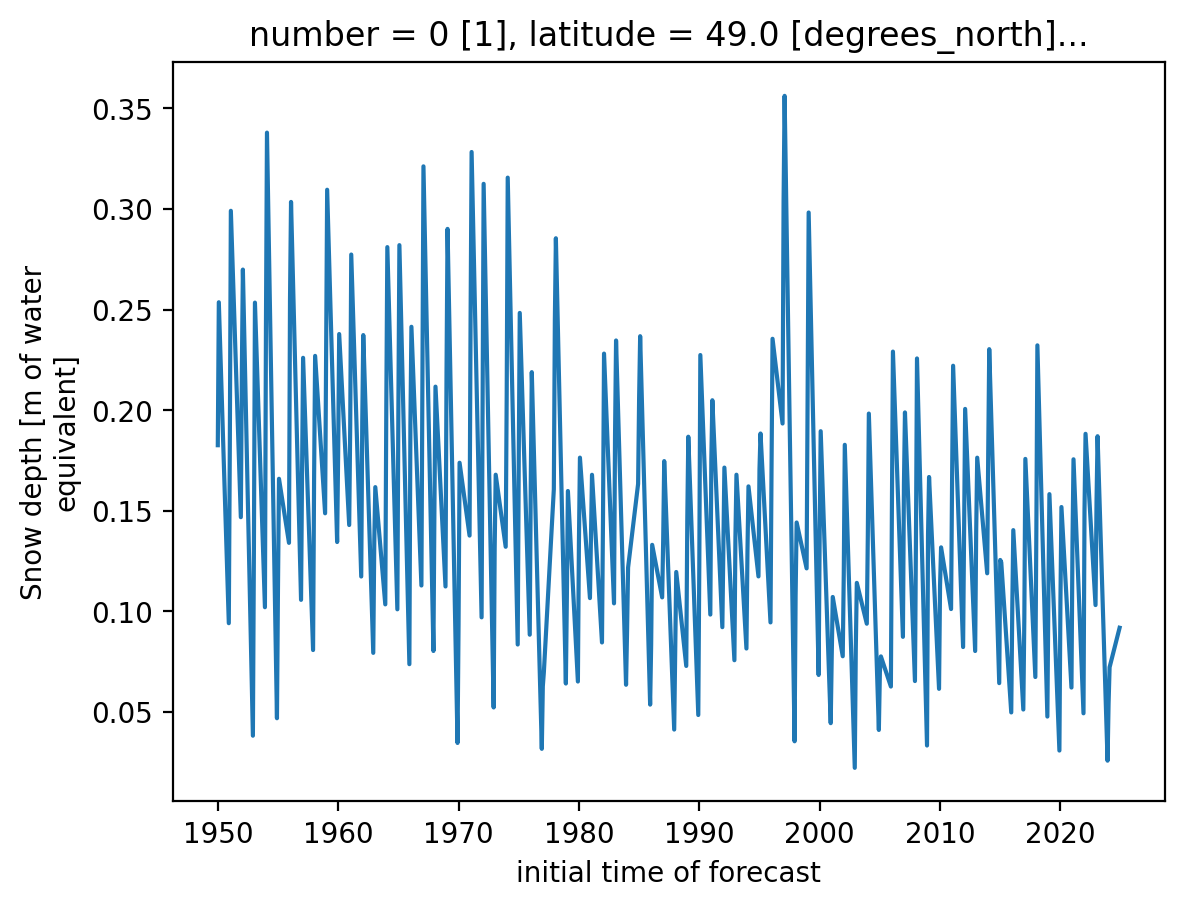

In [5]:
winter_swe = swe.where(swe.valid_time.dt.month.isin([12,1,2]), drop=True) #can change valid time to time on your own
winter_swe.sd.sel(latitude=49.0,longitude=124.0,method='nearest').plot()

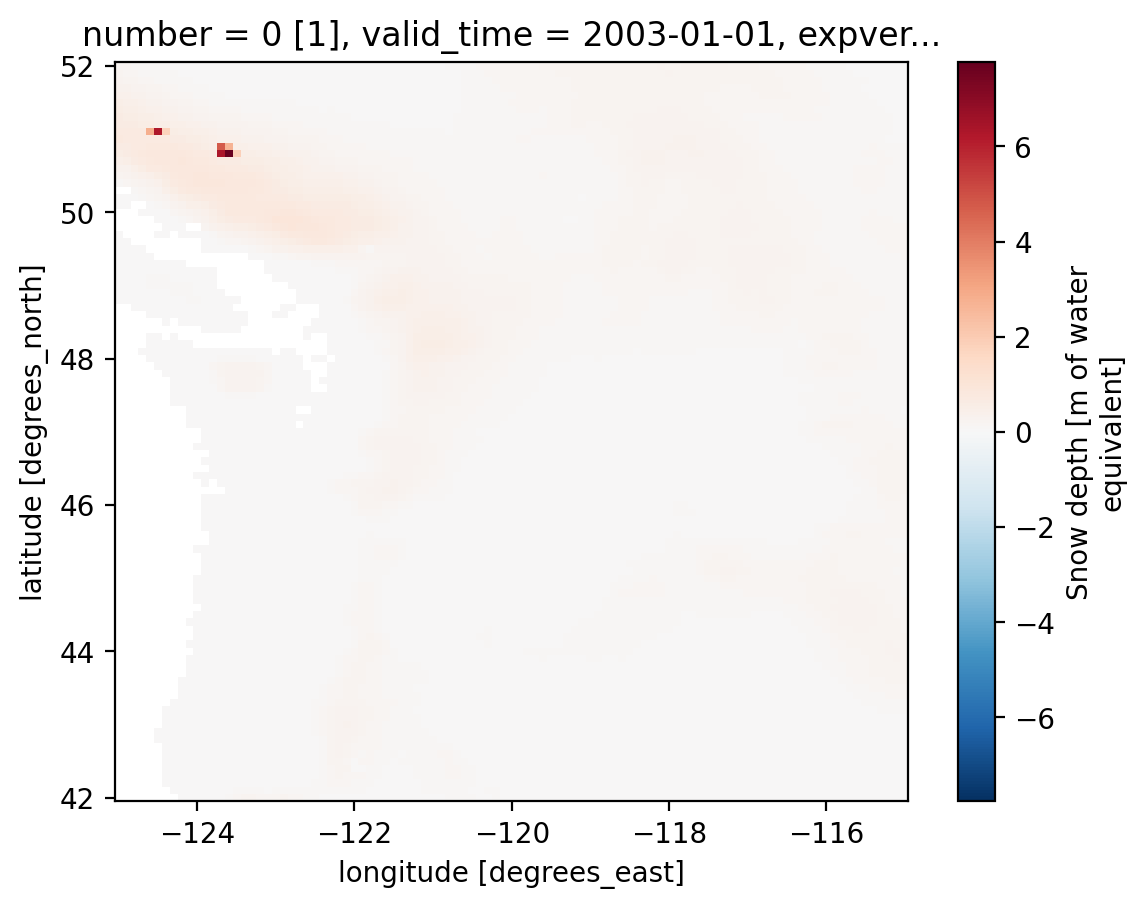

In [6]:
winter_swe.sd.sel(valid_time='2003-01-01',method='nearest').plot()

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


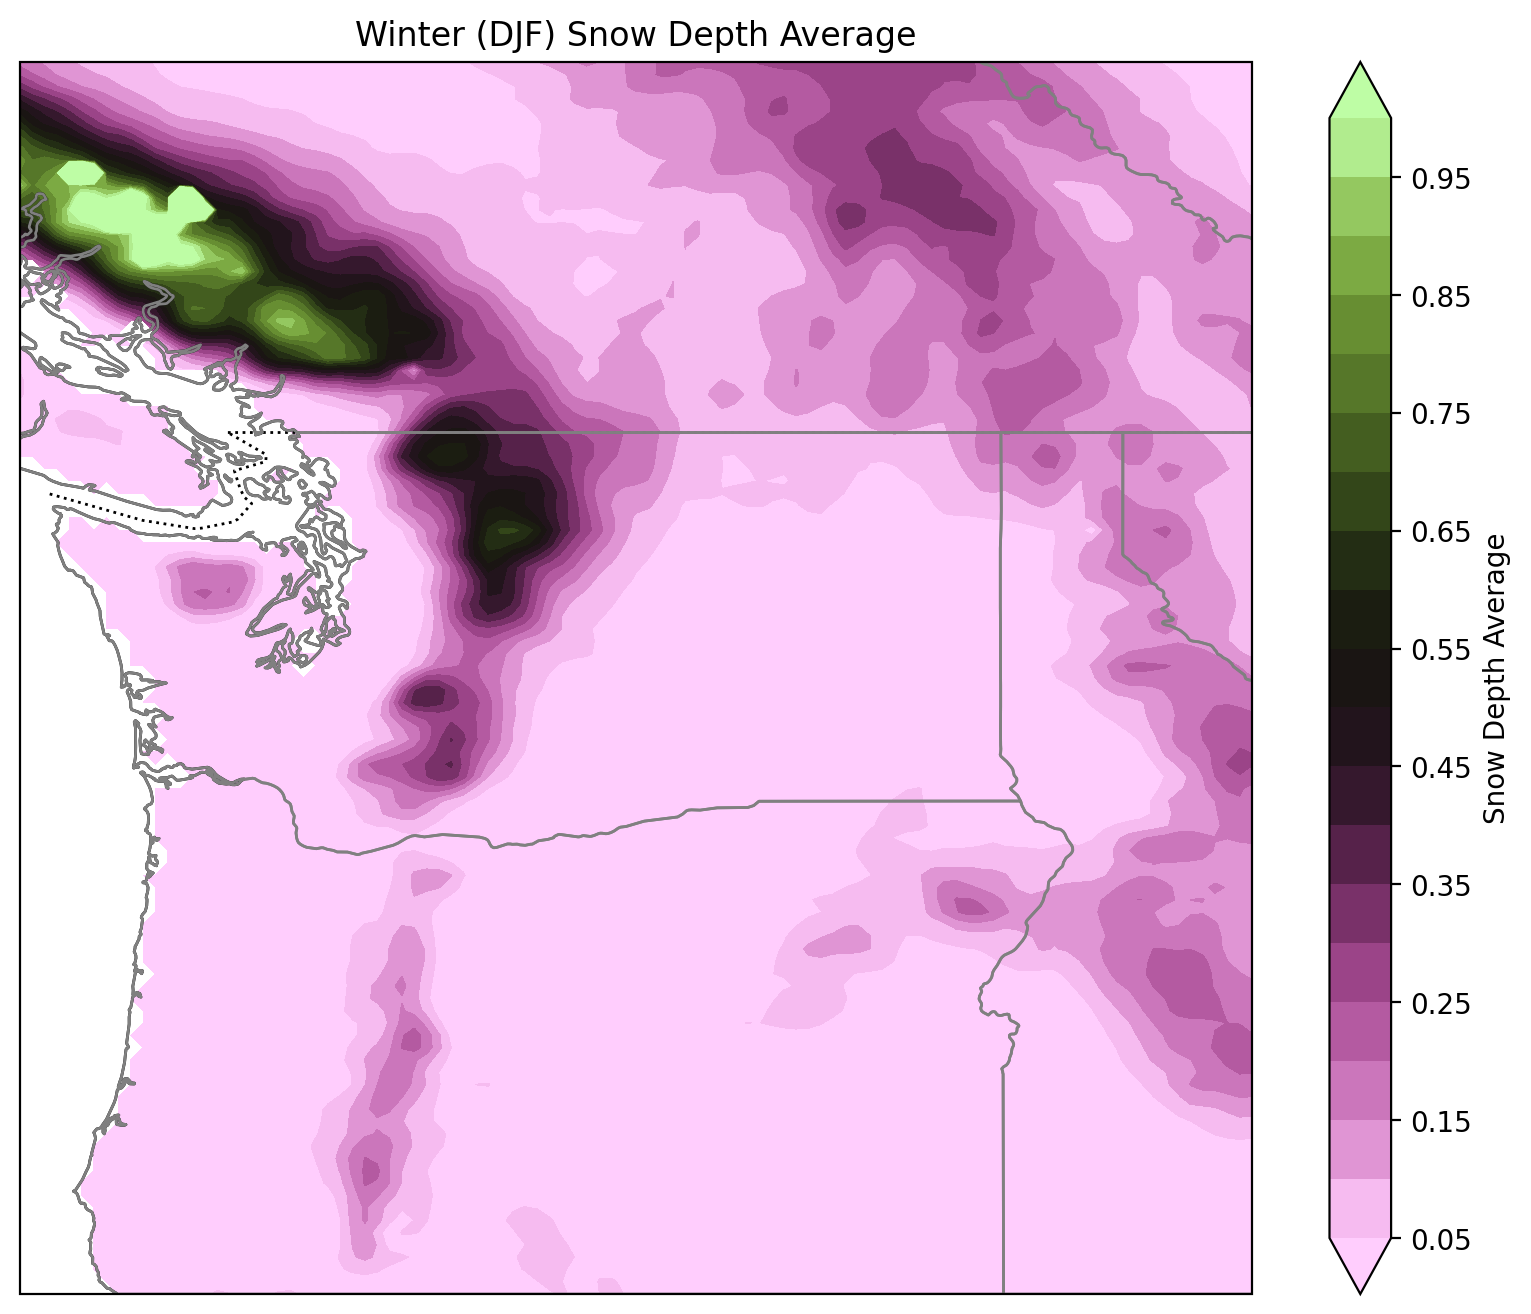

In [7]:
## swe map
swemap = swe.mean(dim='valid_time')
firsthalf = swe.sel(valid_time=slice('1950-01-01','1987-02-01')).mean(dim='valid_time')
secondhalf = swe.sel(valid_time=slice('1988-12-01','2024-02-01')).mean(dim='valid_time')

# Create a figure and axes with a PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Determine the spatial extent from the data.
# Adjust these coordinate names if your dataset uses different ones.
lon_min = float(swemap.longitude.min())
lon_max = float(swemap.longitude.max())
lat_min = float(swemap.latitude.min())
lat_max = float(swemap.latitude.max())

levels = np.arange(0, 1.05, 0.05)
levels = levels[levels != 0]
print(levels)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add geographic features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Plot the temperature anomaly using a filled contour plot.
# Replace 'temperature' with your variable name if it differs.
contour = ax.contourf(
    swemap.longitude,
    swemap.latitude,
    swemap.sd,
    transform=ccrs.PlateCarree(),
    cmap='vanimo',
    extend='both',
    levels=levels
)

# Add a colorbar with a label indicating the anomaly units
cbar = plt.colorbar(contour, ax=ax, pad=0.05)
cbar.set_label('Snow Depth Average')

# Add a title to the map
plt.title('Winter (DJF) Snow Depth Average')

# Display the map
plt.show()

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


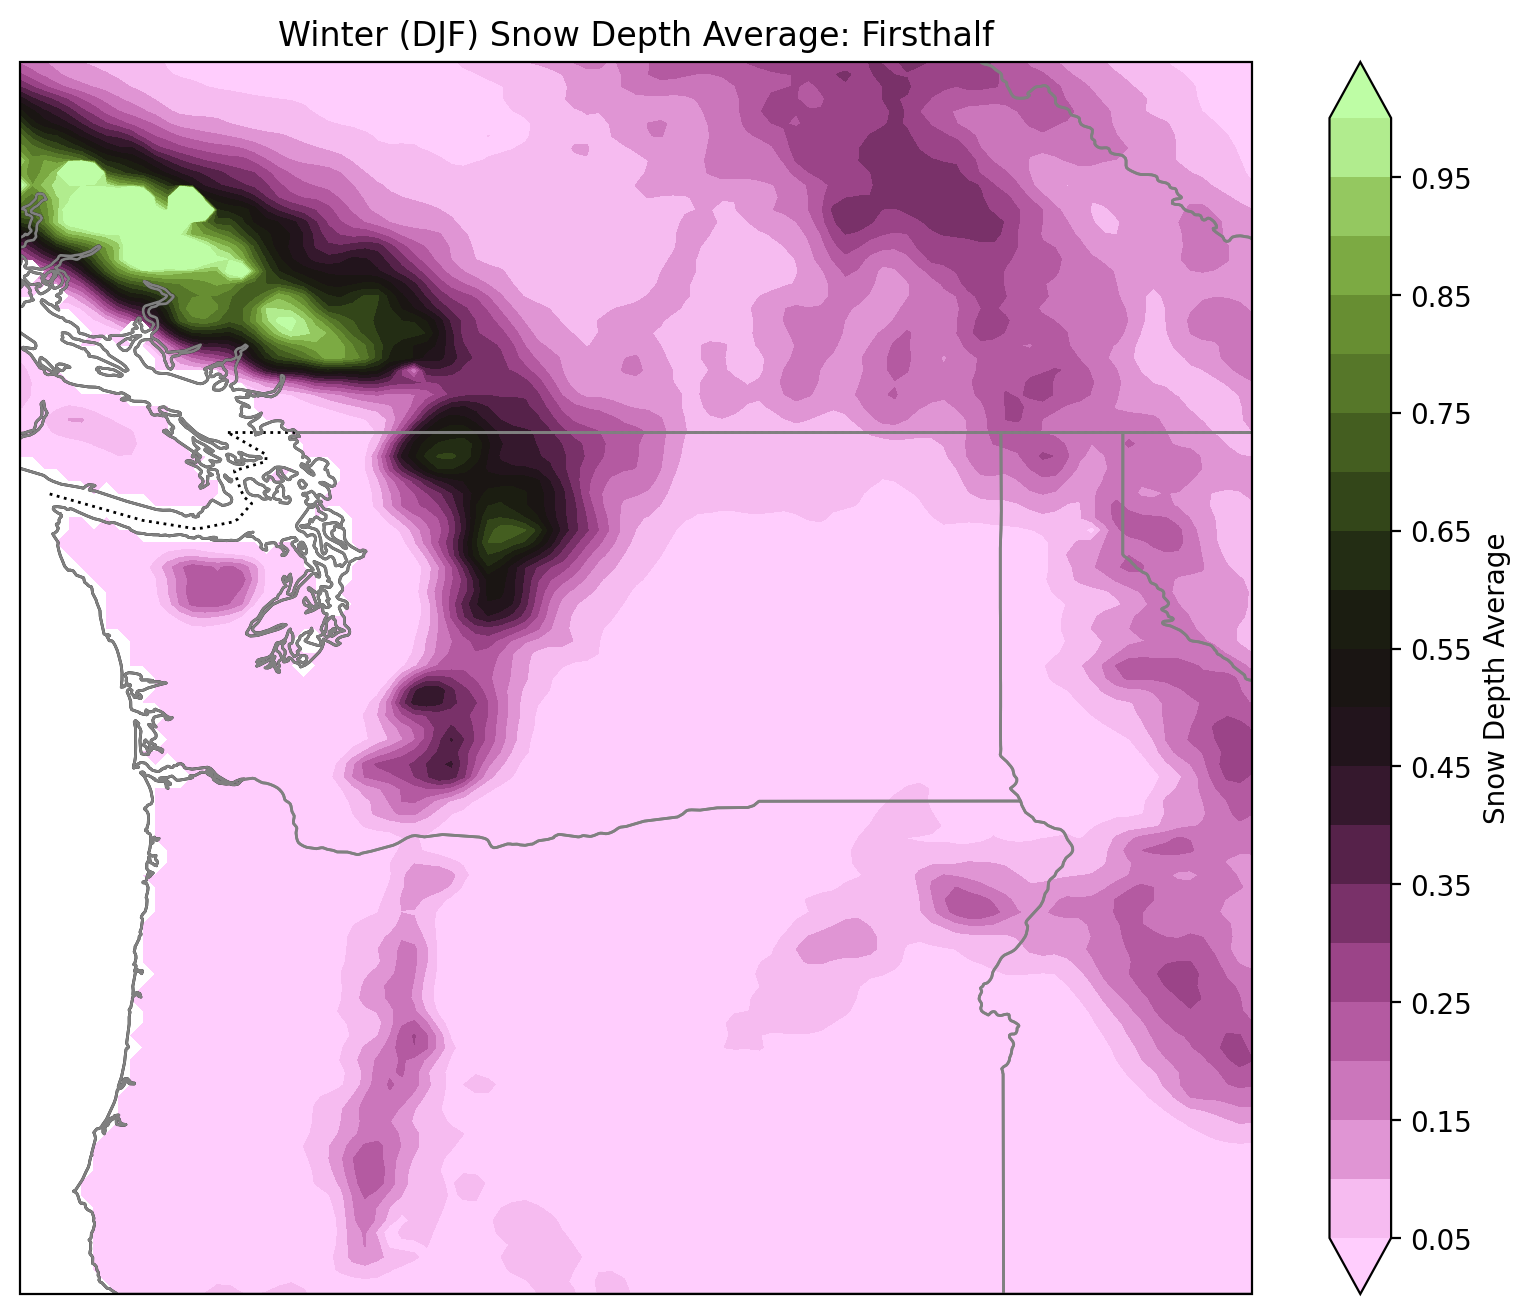

<Figure size 640x480 with 0 Axes>

In [8]:
# Create a figure and axes with a PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Determine the spatial extent from the data.
# Adjust these coordinate names if your dataset uses different ones.
lon_min = float(firsthalf.longitude.min())
lon_max = float(firsthalf.longitude.max())
lat_min = float(firsthalf.latitude.min())
lat_max = float(firsthalf.latitude.max())

levels = np.arange(0, 1.05, 0.05)
levels = levels[levels != 0]
print(levels)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add geographic features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Plot the temperature anomaly using a filled contour plot.
# Replace 'temperature' with your variable name if it differs.
contour = ax.contourf(
    firsthalf.longitude,
    firsthalf.latitude,
    firsthalf.sd,
    transform=ccrs.PlateCarree(),
    cmap='vanimo',
    extend='both',
    levels=levels
)

# Add a colorbar with a label indicating the anomaly units
cbar = plt.colorbar(contour, ax=ax, pad=0.05)
cbar.set_label('Snow Depth Average')

# Add a title to the map
plt.title('Winter (DJF) Snow Depth Average: Firsthalf')

# Display the map
plt.show()

plt.savefig('Winter (DJF) Snow Depth Average Firsthalf.png', dpi = 300,bbox_inches = 'tight',facecolor='white')

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


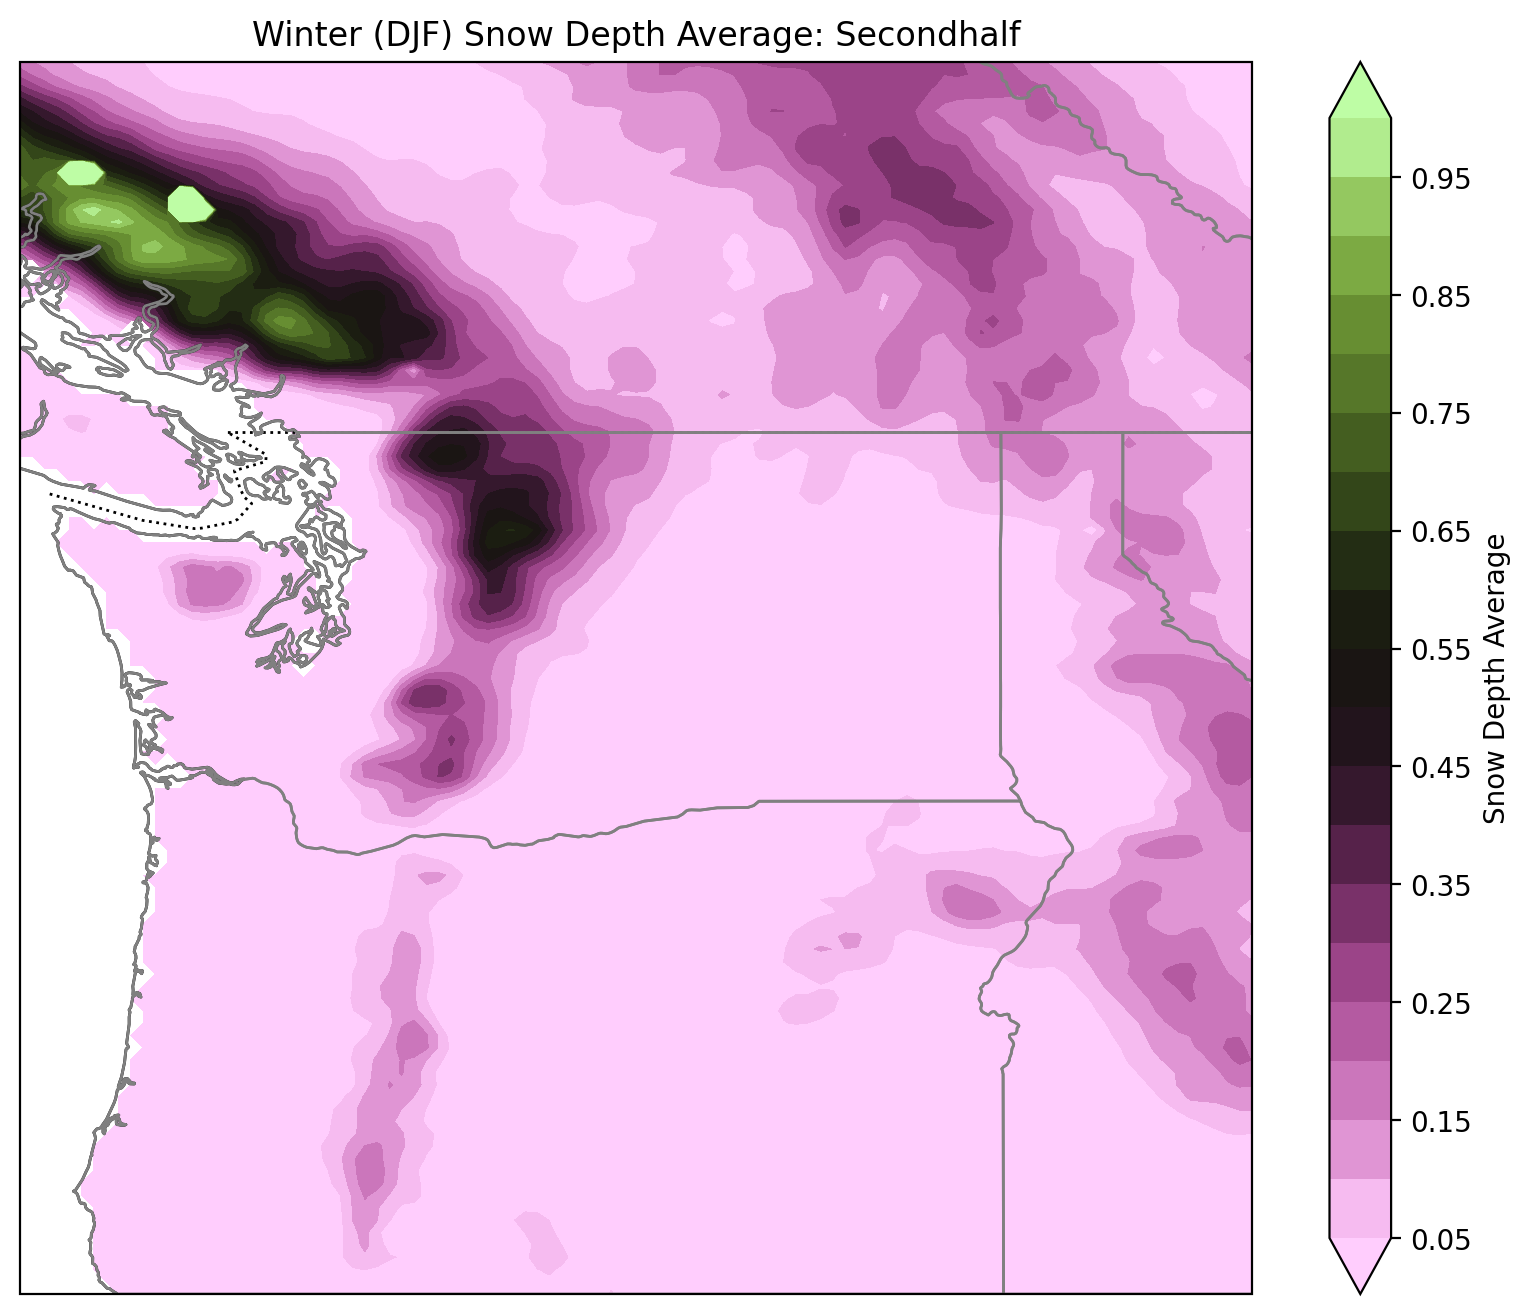

<Figure size 640x480 with 0 Axes>

In [9]:
# Create a figure and axes with a PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Determine the spatial extent from the data.
# Adjust these coordinate names if your dataset uses different ones.
lon_min = float(secondhalf.longitude.min())
lon_max = float(secondhalf.longitude.max())
lat_min = float(secondhalf.latitude.min())
lat_max = float(secondhalf.latitude.max())

levels = np.arange(0, 1.05, 0.05)
levels = levels[levels != 0]
print(levels)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add geographic features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Plot the temperature anomaly using a filled contour plot.
# Replace 'temperature' with your variable name if it differs.
contour = ax.contourf(
    secondhalf.longitude,
    secondhalf.latitude,
    secondhalf.sd,
    transform=ccrs.PlateCarree(),
    cmap='vanimo',
    extend='both',
    levels=levels
)

# Add a colorbar with a label indicating the anomaly units
cbar = plt.colorbar(contour, ax=ax, pad=0.05)
cbar.set_label('Snow Depth Average')

# Add a title to the map
plt.title('Winter (DJF) Snow Depth Average: Secondhalf')

# Display the map
plt.show()

plt.savefig('Winter (DJF) Snow Depth Average Secondhalf.png', dpi = 300,bbox_inches = 'tight',facecolor='white')

[-2.50000000e-01 -2.40000000e-01 -2.30000000e-01 -2.20000000e-01
 -2.10000000e-01 -2.00000000e-01 -1.90000000e-01 -1.80000000e-01
 -1.70000000e-01 -1.60000000e-01 -1.50000000e-01 -1.40000000e-01
 -1.30000000e-01 -1.20000000e-01 -1.10000000e-01 -1.00000000e-01
 -9.00000000e-02 -8.00000000e-02 -7.00000000e-02 -6.00000000e-02
 -5.00000000e-02 -4.00000000e-02 -3.00000000e-02 -2.00000000e-02
 -1.00000000e-02  2.22044605e-16  1.00000000e-02  2.00000000e-02
  3.00000000e-02  4.00000000e-02  5.00000000e-02  6.00000000e-02
  7.00000000e-02  8.00000000e-02  9.00000000e-02  1.00000000e-01
  1.10000000e-01  1.20000000e-01  1.30000000e-01  1.40000000e-01
  1.50000000e-01  1.60000000e-01  1.70000000e-01  1.80000000e-01
  1.90000000e-01  2.00000000e-01  2.10000000e-01  2.20000000e-01
  2.30000000e-01  2.40000000e-01  2.50000000e-01]


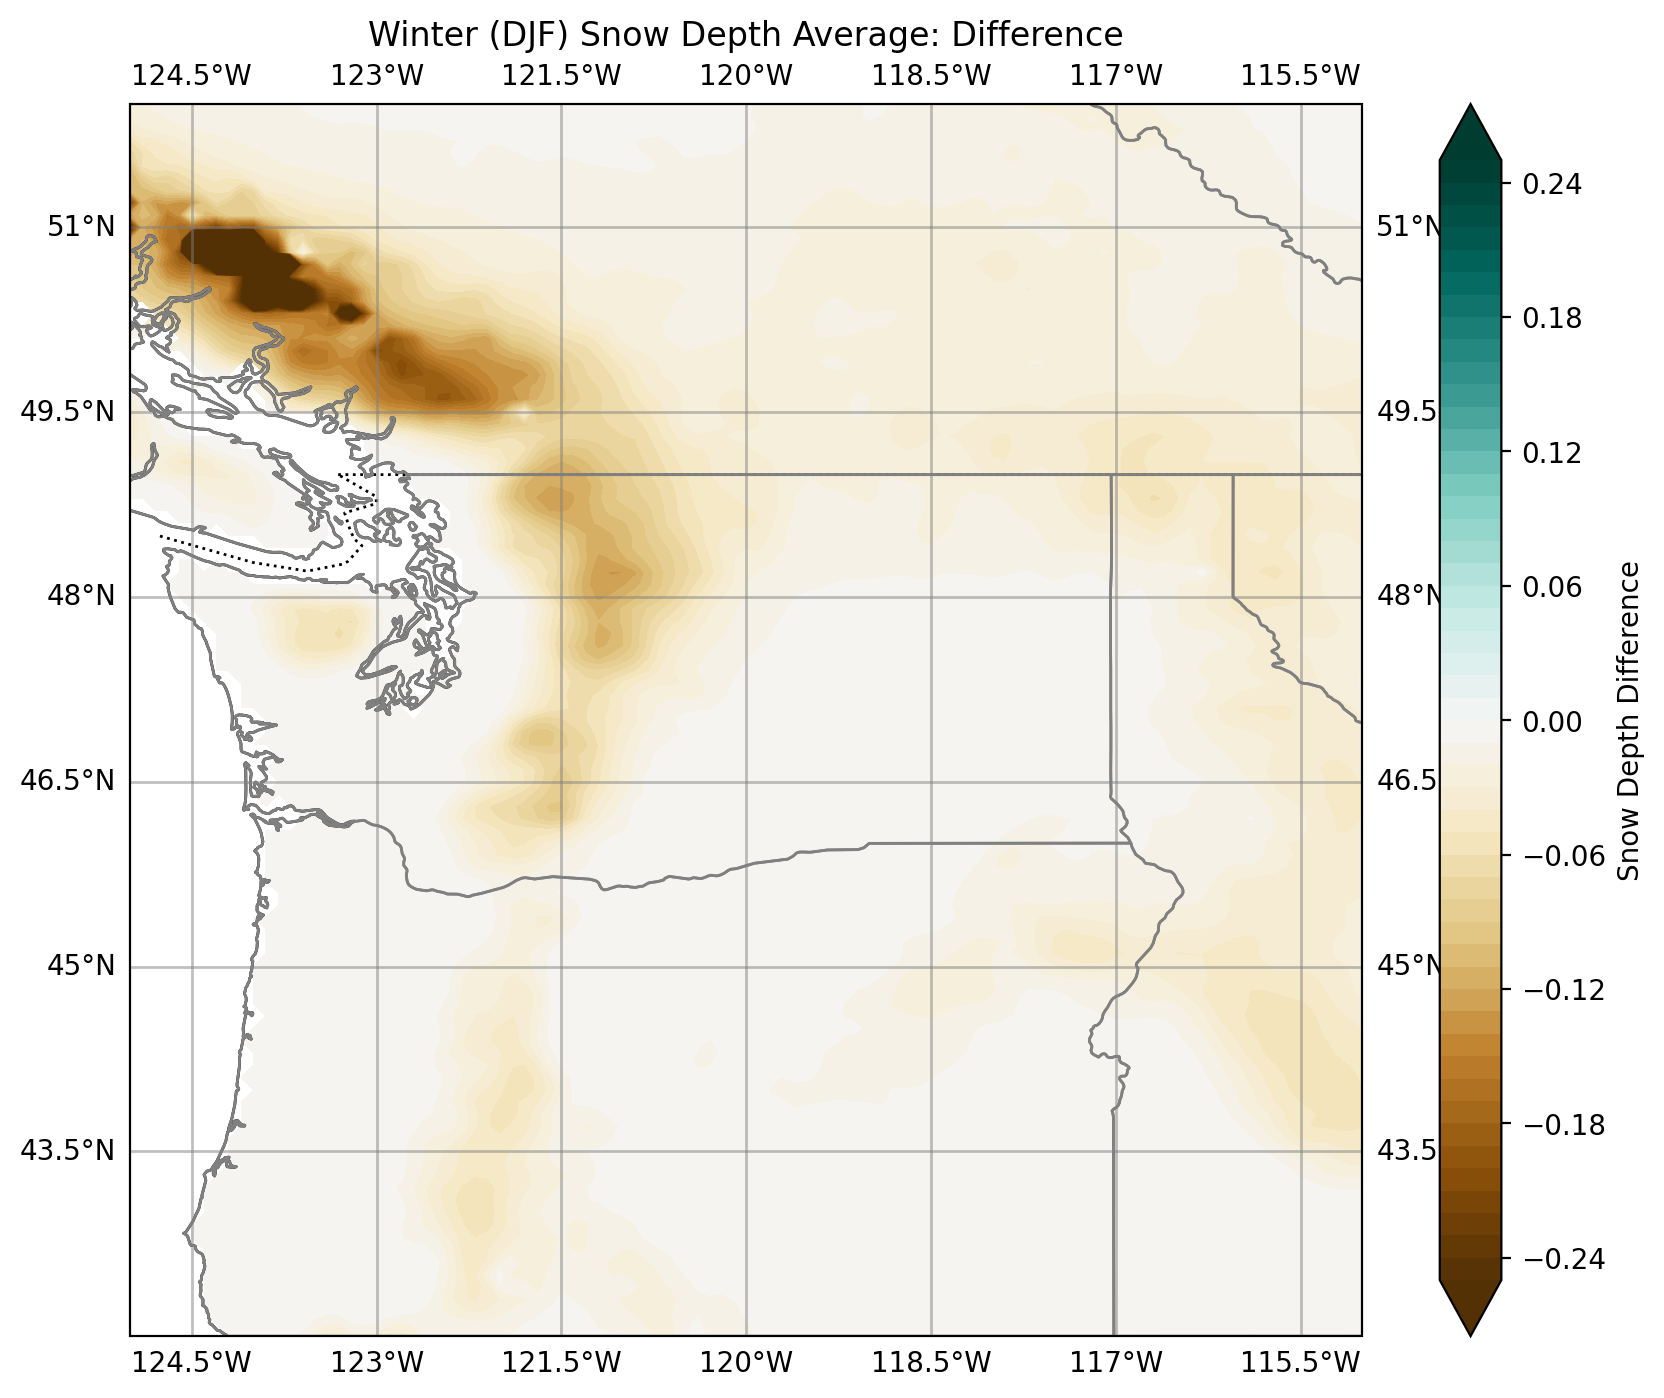

<Figure size 640x480 with 0 Axes>

In [21]:
diff = secondhalf-firsthalf

# Create a figure and axes with a PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Determine the spatial extent from the data.
# Adjust these coordinate names if your dataset uses different ones.
lon_min = float(diff.longitude.min())
lon_max = float(diff.longitude.max())
lat_min = float(diff.latitude.min())
lat_max = float(diff.latitude.max())

# levels = np.arange(0, 1.05, 0.05)
# levels = levels[levels != 0]
# print(levels)
levels = np.arange(-0.25, 0.26, 0.01)
levels = levels[levels !=0]
print(levels)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add geographic features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', 
                  alpha=0.5)

# Plot the temperature anomaly using a filled contour plot.
# Replace 'temperature' with your variable name if it differs.
contour = ax.contourf(
    diff.longitude,
    diff.latitude,
    diff.sd,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    extend='both',
    levels=levels
)

# northlat=[44, 42] #can adjust these to southlat and westlon
# westlon=[-120.5, -117.5, -115.5, -111.5, -110.5]

# for lat in northlat:
#     southlat = lat - 1.0
#     for lon in westlon:
#         eastlon = lon + 1.0

# # Define the bounding box (min_lon, min_lat, width, height)
#         bbox = [lon, lat, 1, 1] #
#        # [-124.5, 50, 1, 1]  # Example: [lon, lat, width, height]

# # Create and add the rectangle to the map
#         rect = mpatches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
#                  linewidth=2, edgecolor='red', facecolor='none', 
#                  transform=ccrs.PlateCarree())

#         ax.add_patch(rect)

bbox1 = [123, 49, 1, 1]
rect = mpatches.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3], 
                 linewidth=2, edgecolor='red', facecolor='none',
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox2 = [120, 49, 1, 1]
rect = mpatches.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox3 = [124.5, 47.5, 1, 1]
rect = mpatches.Rectangle((bbox3[0], bbox3[1]), bbox3[2], bbox3[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox4 = [121.5, 47.5, 1, 1]
rect = mpatches.Rectangle((bbox4[0], bbox4[1]), bbox4[2], bbox4[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox5 = [118.5, 47.5, 1, 1]
rect = mpatches.Rectangle((bbox5[0], bbox5[1]), bbox5[2], bbox5[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add a colorbar with a label indicating the anomaly units
cbar = plt.colorbar(contour, ax=ax, pad=0.05)
cbar.set_label('Snow Depth Difference')

# Add a title to the map
plt.title('Winter (DJF) Snow Depth Average: Difference')

# Display the map
plt.show()

plt.savefig('Winter (DJF) Snow Depth Average Difference.png', dpi = 300,bbox_inches = 
            'tight',facecolor='white')

[-2.50000000e-01 -2.40000000e-01 -2.30000000e-01 -2.20000000e-01
 -2.10000000e-01 -2.00000000e-01 -1.90000000e-01 -1.80000000e-01
 -1.70000000e-01 -1.60000000e-01 -1.50000000e-01 -1.40000000e-01
 -1.30000000e-01 -1.20000000e-01 -1.10000000e-01 -1.00000000e-01
 -9.00000000e-02 -8.00000000e-02 -7.00000000e-02 -6.00000000e-02
 -5.00000000e-02 -4.00000000e-02 -3.00000000e-02 -2.00000000e-02
 -1.00000000e-02  2.22044605e-16  1.00000000e-02  2.00000000e-02
  3.00000000e-02  4.00000000e-02  5.00000000e-02  6.00000000e-02
  7.00000000e-02  8.00000000e-02  9.00000000e-02  1.00000000e-01
  1.10000000e-01  1.20000000e-01  1.30000000e-01  1.40000000e-01
  1.50000000e-01  1.60000000e-01  1.70000000e-01  1.80000000e-01
  1.90000000e-01  2.00000000e-01  2.10000000e-01  2.20000000e-01
  2.30000000e-01  2.40000000e-01  2.50000000e-01]


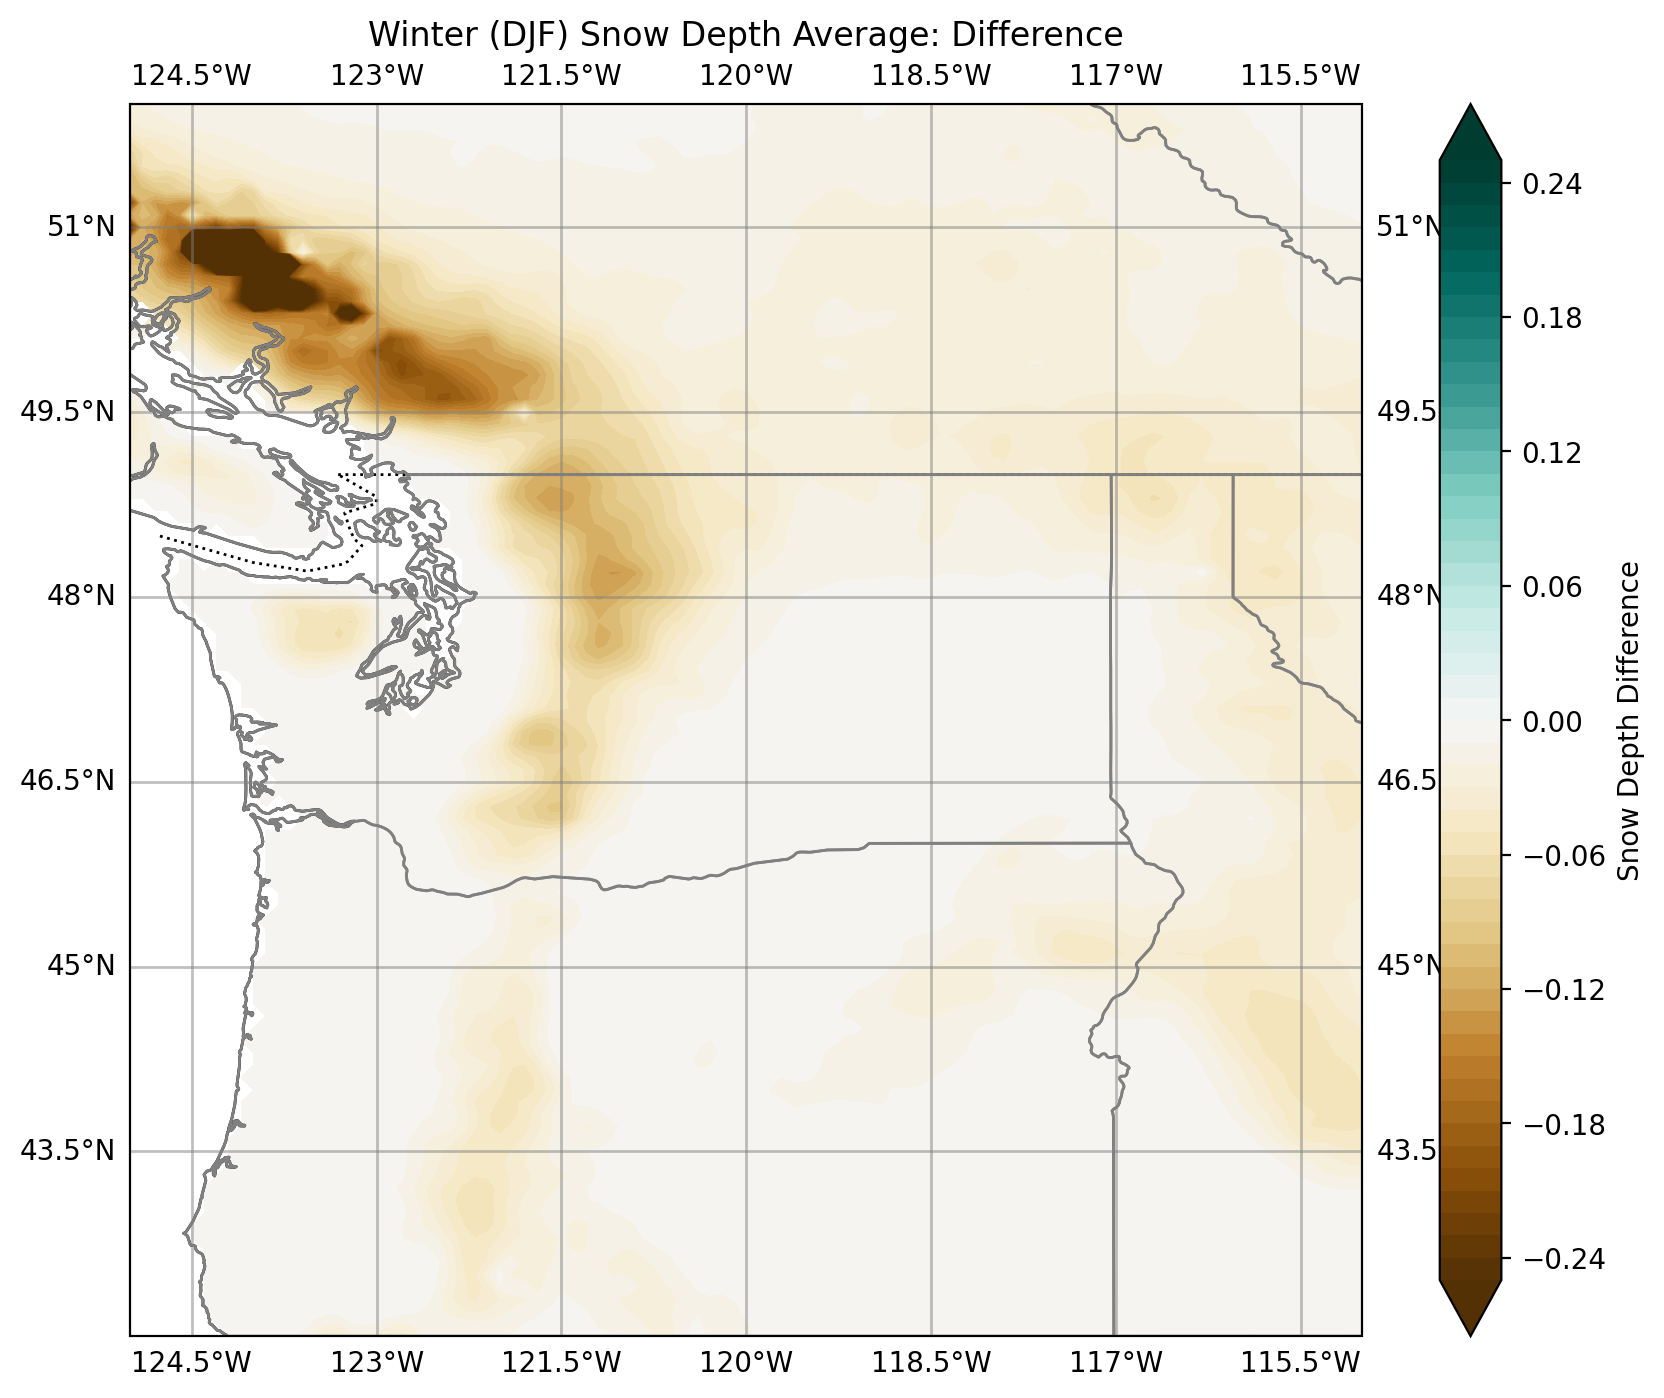

<Figure size 640x480 with 0 Axes>

In [11]:
diff = secondhalf-firsthalf

# Create a figure and axes with a PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Determine the spatial extent from the data.
# Adjust these coordinate names if your dataset uses different ones.
lon_min = float(diff.longitude.min())
lon_max = float(diff.longitude.max())
lat_min = float(diff.latitude.min())
lat_max = float(diff.latitude.max())

# levels = np.arange(0, 1.05, 0.05)
# levels = levels[levels != 0]
# print(levels)
levels = np.arange(-0.25, 0.26, 0.01)
levels = levels[levels !=0]
print(levels)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add geographic features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', 
                  alpha=0.5)

# Plot the temperature anomaly using a filled contour plot.
# Replace 'temperature' with your variable name if it differs.
contour = ax.contourf(
    diff.longitude,
    diff.latitude,
    diff.sd,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    extend='both',
    levels=levels
)

# Define the bounding box (min_lon, min_lat, width, height)
bbox1 = [123, 49, 1, 1]
rect = mpatches.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox2 = [120, 49, 1, 1]
rect = mpatches.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox3 = [124.5, 47.5, 1, 1]
rect = mpatches.Rectangle((bbox3[0], bbox3[1]), bbox3[2], bbox3[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox4 = [121.5, 47.5, 1, 1]
rect = mpatches.Rectangle((bbox4[0], bbox4[1]), bbox4[2], bbox4[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

bbox5 = [118.5, 47.5, 1, 1]
rect = mpatches.Rectangle((bbox5[0], bbox5[1]), bbox5[2], bbox5[3], 
                 linewidth=2, edgecolor='red', facecolor='none', 
                 transform=ccrs.PlateCarree())
ax.add_patch(rect)

# Add a colorbar with a label indicating the anomaly units
cbar = plt.colorbar(contour, ax=ax, pad=0.05)
cbar.set_label('Snow Depth Difference')

# Add a title to the map
plt.title('Winter (DJF) Snow Depth Average: Difference') #difference from secondhalf - firsthalf ([1988-12-01 to 2024-02-01] - [1950-01-01 to 1987-02-01])

# Display the map
plt.show()

plt.savefig('Winter (DJF) Snow Depth Average Difference.png', dpi = 300,bbox_inches = 
            'tight',facecolor='white')

In [12]:
swemap

<xarray.Dataset> Size: 42kB
Dimensions:    (latitude: 101, longitude: 101)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 808B 52.0 51.9 51.8 51.7 ... 42.2 42.1 42.0
  * longitude  (longitude) float64 808B -125.0 -124.9 -124.8 ... -115.1 -115.0
Data variables:
    sd         (latitude, longitude) float32 41kB 0.1782 0.1585 ... 0.02764

In [13]:
dat1 = xr.open_dataset('era5_monthly_snowfall.nc')
dat1 = dat1.sel(expver=1).drop('expver')*1000
dat1 = dat1*39.3701
dat1 = dat1.sel(time=slice("1958-01-01","2022-12-01")) #ignore most recent month (incomplete)
print(dat1)

lat = dat1.latitude
lon = dat1.longitude
timz = dat1.time.shape[0]
#print(timz)

FileNotFoundError: [Errno 2] No such file or directory: '/homes/metogra/enaide/AOSC498/era5_monthly_snowfall.nc'

In [ ]:
dat2 = xr.open_dataset('era5_monthly_update.nc')
dat2 = dat2.sel(expver=1).drop('expver')*1000
dat2 = dat2*39.3701
dat2 = dat2.sel(time=slice("2023-01-01","2023-12-01")) 
#print(dat2)

In [ ]:
dat3 = xr.open_dataset('era5_monthly_update_2024.nc')
dat3 = dat3.drop('expver')*1000
#dat3 = dat3*1000
dat3 = dat3*39.3701

datefix = pd.date_range(start='1/1/2024', end='9/1/2024', freq='MS')    
dat3['date'] = datefix
dat3 = dat3.rename({'date': 'time'})

print(dat3)


dat = xr.merge([dat1,dat2,dat3])
print(dat) 


In [ ]:
subdat = dat.sel(time = "1999-04-01")
mapz = subdat

################ INSPECT ANOMALY MAP FOR ONE MONTH
proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat)  

plt.figure(4,figsize=(12, 7))
ax = plt.axes(projection=proj_map)
ax.coastlines()
levels = np.arange(0, 9, 1)
#cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz.sf),cmap='BrBG',transform=proj_dta,extend='both')
cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz.sf), levels=levels,cmap='cool',transform=proj_dta,extend='both')
ax.set_extent((235, 293, 24, 46))
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
################

## Now take monthly climo to form anomaly

In [ ]:
# Take 30 year time slice (climo range)
prcp30yr = dat.sel(time=slice("1991-01","2020-12"))
climatology = prcp30yr.groupby("time.month").mean("time") # 30 year climo
prcpa = dat.groupby("time.month") - climatology
#prcpa = dat

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat)  

################ INSPECT ANOMALY MAP FOR ONE MONTH
import matplotlib.colors as mcolors
mapz = prcpa.sel(time='1999-04-01')
plt.figure(4,figsize=(12, 7))
ax = plt.axes(projection=proj_map)
ax.coastlines()
#levels = np.arange(-5, 5.5, .5)
levels = np.arange(-10, 10.5, 1)
levels = levels[levels != 0]
print(levels)
cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz.sf),levels=levels,cmap=snowmap,transform=proj_dta,extend='both')
#cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz.sf),levels=levels,cmap='bwr_r',transform=proj_dta,extend='both')
ax.set_extent((235, 293, 24, 46))
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_ticks(levels)
################

## Now do 3mo rolling avearge

In [ ]:
seasavg = prcpa.rolling(time=3, center=True).mean() # AVERAGE
#seasavg = prcpa.rolling(time=3, center=True).sum() # SUM
# Note that first and last points are now NaN 

################ INSPECT SEASONAL ANOM MAP
mapz = seasavg.sel(time='1999-04-01') #AMJ 2023
plt.figure(4,figsize=(12, 7))
ax = plt.axes(projection=proj_map)
ax.coastlines()
#levels = np.arange(-2, 2.25, .25)
levels = np.arange(-10, 10.5, 1)
levels = levels[levels != 0]
print(levels)
cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz.sf),levels=levels,cmap=snowmap,transform=proj_dta,extend='both')
ax.set_extent((235, 293, 24, 46))
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_ticks(levels)

################

In [ ]:
## Drop NAN at beginning and end of time 
onefil = seasavg.dropna('time', how='all')
print(onefil)

# Pick the season to focus on (AFTER PEAK, DJF, JFM, etc)

In [ ]:
SEA = 2
onsea = onefil.where(onefil['time.month'] == SEA, drop=True)

# Reorder dim 
onsea = onsea.transpose("time","latitude", "longitude")

print(onsea)

In [ ]:

################ INSPECT SEASONAL ANOM MAP
mapz = onsea.sel(time='2024-02-01') 
plt.figure(4,figsize=(12, 7))
ax = plt.axes(projection=proj_map)
ax.coastlines()
#levels = np.arange(-2, 2.25, .25)
levels = np.arange(-20, 20.5, 2)
levels = levels[levels != 0]
print(levels)
cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz.sf),levels=levels,cmap=snowmap,transform=proj_dta,extend='both')
ax.set_extent((235, 293, 24, 46))
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_ticks(levels)
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')

################

## Remove linear trend from precip anomalies (DETREND) -- can comment out detrending part as needed 

In [ ]:
N, nlat, nlon = onsea.sf.shape
print(N, nlat, nlon)

p = 2
XX = np.empty((N,p))
XX[:,0]=1
timlin = np.arange(0,len(onsea.time),1)
XX[:,1]=timlin  #time

#print(XX)
field = onsea.sf
#print(field)
y = field.values.reshape(N,nlat *nlon)

beta = np.linalg.inv(XX.T@XX)@XX.T@y
yhat = XX@beta

print(beta.shape)
print(yhat.shape)

mapz1 = beta[0,:] # intercept
mapz2 = beta[1,:] # time (trend)
detrend_field = y - yhat # Detrend field

#print(mapz2.shape)
#print(detrend_field.shape)

# Check detrended calculation
p = 2
XX = np.empty((N,p))
XX[:,0]=1
timlin = np.arange(0,len(onsea.time),1)
XX[:,1]=timlin  #time
y = detrend_field
beta = np.linalg.inv(XX.T@XX)@XX.T@y
yhat = XX@beta
mapz3 = beta[1,:] # time (trend) map -- make sure this is zero 

mapz1 = mapz1.reshape(nlat,nlon) # intercept
mapz2 = mapz2.reshape(nlat,nlon) # trend
mapz3 = mapz3.reshape(nlat,nlon) # no trend

# Overwrite with detrended GPH
nw = detrend_field.reshape(N,nlat,nlon)

nwr = xr.DataArray(nw, coords={'time': onsea.time, 'latitude': onsea.latitude, 
                                'longitude': onsea.longitude},
             dims=['time','latitude', 'longitude'])

onsea['sf'] = nwr
print(onsea)

In [ ]:
#in inches/decade

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 6))
ax = plt.axes(projection=proj_map)
ax.coastlines()

#levels = np.arange(-1, 1.1, .1)
levels = np.arange(-5, 5.1, .5)
levels = levels[(levels < -.0001) | (levels > .0001)]
print(levels)
#levels = np.arange(-.5, .55, .05)
#levels = levels[(levels < -.001) | (levels > .001)]
cf = ax.contourf(X_grid,Y_grid,np.squeeze(mapz2*10),levels=levels,cmap=snowmap,transform=proj_dta,extend='both')
#ax.set_extent((235, 293, 24, 46))
ax.set_extent((192, 305, 24, 60))
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, fraction=0.035, extendrect=True)
cbar.set_ticks(levels)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')


#ax.set_extent((110, 340, -10, 75), ccrs.PlateCarree())
plt.title('Snowfall Anomaly Trend (January-March)')
plt.savefig('Snowanom_Trend.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('Snowanom_Trend.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')



In [ ]:
## Save for netcdf file 
snow_data = xr.DataArray(np.squeeze(mapz2*10), coords={'latitude': onsea.latitude, 
                                'longitude': onsea.longitude}, dims=['latitude', 'longitude'])

snow_data = snow_data.to_dataset(name='linear_trend')
print(snow_data)

## Isolate El Nino years (this is after peak so can use for DJF through MAM for example) 

In [ ]:
# weak
yr1 = onsea.where(onsea['time.year'] == 1959,drop=True)
yr2 = onsea.where(onsea['time.year'] == 1970,drop=True)
yr3 = onsea.where(onsea['time.year'] == 1977,drop=True)
yr4 = onsea.where(onsea['time.year'] == 1978,drop=True)
yr5 = onsea.where(onsea['time.year'] == 1980,drop=True)
yr6 = onsea.where(onsea['time.year'] == 2005,drop=True)
yr7 = onsea.where(onsea['time.year'] == 2007,drop=True)
yr8 = onsea.where(onsea['time.year'] == 2019,drop=True)

# moderate
yr9 = onsea.where(onsea['time.year'] == 1964,drop=True)
yr10 = onsea.where(onsea['time.year'] == 1969,drop=True)
yr11 = onsea.where(onsea['time.year'] == 1987,drop=True)
yr12 = onsea.where(onsea['time.year'] == 1995,drop=True)
yr13 = onsea.where(onsea['time.year'] == 2003,drop=True)

# strong
yr14 = onsea.where(onsea['time.year'] == 1966,drop=True)
yr15 = onsea.where(onsea['time.year'] == 1973,drop=True)
yr16 = onsea.where(onsea['time.year'] == 1983,drop=True)
yr17 = onsea.where(onsea['time.year'] == 1988,drop=True) #strong? or moderate
yr18 = onsea.where(onsea['time.year'] == 1992,drop=True)
yr19 = onsea.where(onsea['time.year'] == 1998,drop=True)
yr20 = onsea.where(onsea['time.year'] == 2010,drop=True)
yr21 = onsea.where(onsea['time.year'] == 2016,drop=True)
yr22 = onsea.where(onsea['time.year'] == 2024,drop=True)

# Merge all
#ENyrs = xr.merge([yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9,yr10,yr11,yr12,yr13,yr14,yr15,yr16,yr17,yr18,yr19,yr20,yr21,yr22])

# Just moderate/strong
ENyrs = xr.merge([yr9,yr10,yr11,yr12,yr13,yr14,yr15,yr16,yr17,yr18,yr19,yr20,yr21,yr22])

# Just strong
#ENyrs = xr.merge([yr14,yr15,yr16,yr17,yr18,yr19,yr20,yr21])


print(ENyrs)

## Isolate La Nina years (this is after peak so can use for DJF through MAM for example) 

In [ ]:
# weak
yr1 = onsea.where(onsea['time.year'] == 1965,drop=True)
yr2 = onsea.where(onsea['time.year'] == 1972,drop=True)
yr3 = onsea.where(onsea['time.year'] == 1975,drop=True)
yr4 = onsea.where(onsea['time.year'] == 1984,drop=True)
yr5 = onsea.where(onsea['time.year'] == 2001,drop=True)
yr6 = onsea.where(onsea['time.year'] == 2006,drop=True)
yr7 = onsea.where(onsea['time.year'] == 2009,drop=True)
yr8 = onsea.where(onsea['time.year'] == 2018,drop=True)
yr9 = onsea.where(onsea['time.year'] == 2023,drop=True)

# moderate
yr10 = onsea.where(onsea['time.year'] == 1971,drop=True)
yr11 = onsea.where(onsea['time.year'] == 1985,drop=True)
yr12 = onsea.where(onsea['time.year'] == 1996,drop=True)
yr13 = onsea.where(onsea['time.year'] == 2012,drop=True)
yr14 = onsea.where(onsea['time.year'] == 2021,drop=True)
yr15 = onsea.where(onsea['time.year'] == 2022,drop=True)

# strong
yr16 = onsea.where(onsea['time.year'] == 1974,drop=True)
yr17 = onsea.where(onsea['time.year'] == 1976,drop=True)
yr18 = onsea.where(onsea['time.year'] == 1989,drop=True)
yr19 = onsea.where(onsea['time.year'] == 1999,drop=True)
yr20 = onsea.where(onsea['time.year'] == 2000,drop=True)
yr21 = onsea.where(onsea['time.year'] == 2008,drop=True)
yr22 = onsea.where(onsea['time.year'] == 2011,drop=True)

# Merge all
LNyrs = xr.merge([yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9,yr10,yr11,yr12,yr13,yr14,yr15,yr16,yr17,yr18,yr19,yr20,yr21,yr22])
print(LNyrs)

# Just weak
LNyrs_weak = xr.merge([yr1,yr2,yr3,yr4,yr5,yr6,yr7,yr8,yr9])


## Average and map 

In [ ]:
#avgmap = ENyrs.mean(dim='time',skipna=False)
#avgmap = LNyrs.mean(dim='time',skipna=False)
avgmap = LNyrs_weak.mean(dim='time',skipna=False)

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 6))
ax = plt.axes(projection=proj_map)
ax.coastlines()

levels = np.arange(-10, 10.5, 1)
#levels = np.arange(-.5, .55, .05)
levels = levels[(levels < -.001) | (levels > .001)]
print(levels)
cf = ax.contourf(X_grid,Y_grid,np.squeeze(avgmap.sf),levels=levels,cmap=snowmap,transform=proj_dta,extend='both')
#ax.set_extent((235, 293, 24, 46))
ax.set_extent((192, 305, 24, 60))
#ax.set_extent((270, 305, 30, 55)) #NE
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, fraction=0.035, extendrect=True)
cbar.set_ticks(levels)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')

#plt.title('Average Snowfall Anomaly for La Nina (January-March)')
#plt.savefig('LNcomposite_snowa.png', dpi = 300,bbox_inches = 'tight',facecolor='white')

plt.title('Average Snowfall Anomaly for Weak La Ninas (January-March)')
plt.savefig('LNcomposite_snowa_weak.png', dpi = 300,bbox_inches = 'tight',facecolor='white')

#plt.title('Average Snowfall Anomaly for Strong El Ninos (January-March)')
#plt.savefig('ENcomposite_snowa_str.png', dpi = 300,bbox_inches = 'tight',facecolor='white')

#plt.title('Average Snowfall Anomaly for Moderate-to-Strong El Ninos (January-March)')
#plt.savefig('ENcomposite_snowa_mod_str.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('ENcomposite_snowa_mod_str.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')

#plt.title('Average Snowfall Anomaly for El Ninos (January-March)')
#plt.savefig('ENcomposite_snowa.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('ENcomposite_snowa.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')




In [ ]:
#snow_data2 = xr.DataArray(np.squeeze(avgmap.sf), coords={'latitude': onsea.latitude, 
#                                'longitude': onsea.longitude}, dims=['latitude', 'longitude'])

#snow_data2 = snow_data2.to_dataset(name='weak')
#print(snow_data2)

#snow_data3 = xr.DataArray(np.squeeze(avgmap.sf), coords={'latitude': onsea.latitude, 
#                                'longitude': onsea.longitude}, dims=['latitude', 'longitude'])

#snow_data3 = snow_data3.to_dataset(name='allLN')
#print(snow_data3)

In [ ]:
# Combine and save netcdf
#allsnow = xr.merge([snow_data, snow_data2, snow_data3])
#print(allsnow)

#allsnow.to_netcdf("Snow_Data_LaNina.nc")


In [ ]:
dat = xr.open_dataset('Snow_Data.nc')
avgmap = dat
print(avgmap)

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 12))
ax = plt.axes(projection=proj_map)
ax.coastlines()

levels = np.arange(-10, 10.5, 1)
#levels = np.arange(-.5, .55, .05)
levels = levels[(levels < -.001) | (levels > .001)]
print(levels)
cf = ax.contourf(X_grid,Y_grid,np.squeeze(avgmap.linear_trend),levels=levels,cmap=snowmap,transform=proj_dta,extend='both')
#ax.set_extent((235, 293, 24, 46))
ax.set_extent((192, 305, 24, 60))
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, fraction=0.035, extendrect=True)
cbar.set_ticks(levels)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')
plt.title('Average Snowfall Anomaly for Strong El Ninos (January-March)')


## Add in maps of counts

## Counts of Below and above average (in inches) for La Nina

In [ ]:
print(LNyrs_weak)
print(LNyrs)

In [ ]:

### LA NINA (less than 0 inches) 
#low_snow_ln = xr.where(LNyrs_weak < 0, 1, 0) #set all numbers under 0 inches = 1; others to 0
#summed_lowsnow_ln = low_snow_ln.sum(dim='time')
#high_snow_ln = xr.where(LNyrs_weak > 0, 1, 0) #set all numbers over 0 inches = 1; others to 0
#summed_highsnow_ln = high_snow_ln.sum(dim='time')

low_snow_ln = xr.where(LNyrs < 0, 1, 0) #set all numbers under 0 inches = 1; others to 0
summed_lowsnow_ln = low_snow_ln.sum(dim='time')
high_snow_ln = xr.where(LNyrs > 0, 1, 0) #set all numbers over 0 inches = 1; others to 0
summed_highsnow_ln = high_snow_ln.sum(dim='time')

### LA NINA (less than 1 inches) 
#low_snow_ln = xr.where(LNyrs < -1, 1, 0) 
#summed_lowsnow_ln = low_snow_ln.sum(dim='time')
#high_snow_ln = xr.where(LNyrs > 1, 1, 0)
#summed_highsnow_ln = high_snow_ln.sum(dim='time')

print(summed_lowsnow_ln)

In [ ]:
print(summed_lowsnow_ln.max())

In [ ]:

#cmap = plt.cm.RdYlGn  # define the colormap
cmap = plt.cm.RdGy  # define the colormap

# force the X number color entries to be grey
newcolors = cmap(np.linspace(0, 1, cmap.N))
newcolors = np.flipud(newcolors)
#newcolors[:11,:] =  np.array([.5, .5, .5, 1.0])
newcolors[:11,:] =  np.array([0, 0, 0, 1.0])
MyCmap=colors.ListedColormap(newcolors) # make color map



## La Nina maps

In [ ]:
avgmap = summed_lowsnow_ln
#avgmap = summed_highsnow_ln

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 12))
ax = plt.axes(projection=proj_map)
ax.coastlines()

#levels = np.arange(0, 10, 1) # WEAK LA NINA
levels = np.arange(0, 23, 1)  # ALL LA NINA
print(levels)
#cf = ax.contourf(X_grid,Y_grid,np.squeeze(avgmap.sf),levels=levels,cmap=MyCmap,transform=proj_dta)
#cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(avgmap.sf),vmin=0,vmax=9,cmap=MyCmap,transform=proj_dta) # WEAK LA NINA
cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(avgmap.sf),vmin=0,vmax=22,cmap=MyCmap,transform=proj_dta) # ALL LA NINA

#ax.set_extent((235, 293, 24, 46))
ax.set_extent((192, 305, 24, 60))
#ax.set_extent((270, 305, 30, 55)) #NE
cbar = plt.colorbar(cf, orientation='horizontal', ticks=levels, pad=0.04, aspect=50, fraction=0.035, extendrect=True)
#cbar.set_ticks(levels)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')


#plt.title('Number of Weak La Nina Winters with Below Average Snowfall (January-March)')
#plt.savefig('LNcountBE_snowa_weak.png', dpi = 300,bbox_inches = 'tight',facecolor='white')

plt.title('Number of La Ninas with Below-Average Snowfall (January-March)')
plt.savefig('LNcountBE_snowa.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('LNcountBE_snowa.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')



In [ ]:
## Save for netcdf file 
snow_counts = xr.DataArray(np.squeeze(avgmap.sf), coords={'latitude': onsea.latitude, 
                                'longitude': onsea.longitude}, dims=['latitude', 'longitude'])

snow_counts = snow_counts.to_dataset(name='counts')
print(snow_counts)
snow_counts.to_netcdf("Snow_Counts.nc")

## El Nino Maps

## Counts of Below and above average (in inches) for El Nino

In [ ]:
print(ENyrs)

### EL NINO (less than 0 inches) 
low_snow_en = xr.where(ENyrs < 0, 1, 0) #set all numbers under 0 inches = 1; others to 0
summed_lowsnow_en = low_snow_en.sum(dim='time')
high_snow_en = xr.where(ENyrs > 0, 1, 0) #set all numbers over 0 inches = 1; others to 0
summed_highsnow_en = high_snow_en.sum(dim='time')

### EL NINO (less than 1 inches) 
#low_snow_en = xr.where(ENyrs < -1, 1, 0) 
#summed_lowsnow_en = low_snow_en.sum(dim='time')
#high_snow_en = xr.where(ENyrs > 1, 1, 0) 
#summed_highsnow_en = high_snow_en.sum(dim='time')

#print(summed_lowsnow_en)

In [ ]:
avgmap = summed_lowsnow_en

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 12))
ax = plt.axes(projection=proj_map)
ax.coastlines()

levels = np.arange(0, 14, 1)
#levels = np.arange(0, 22, 1)
print(levels)
#cf = ax.contourf(X_grid,Y_grid,np.squeeze(avgmap.sf),levels=levels,cmap=MyCmap,transform=proj_dta)
cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(avgmap.sf),vmin=0,vmax=13,cmap=MyCmap,transform=proj_dta)
#cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(avgmap.sf),vmin=0,vmax=21,cmap=MyCmap,transform=proj_dta)
#ax.set_extent((235, 293, 24, 46))
ax.set_extent((192, 305, 24, 60))
cbar = plt.colorbar(cf, orientation='horizontal', ticks=levels, pad=0.04, aspect=50, fraction=0.035, extendrect=True)
#cbar.set_ticks(levels)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')


#plt.title('Number of Moderate-to-Strong El Nino Winters with Below Average Snowfall (January-March)')
#plt.savefig('ENcountBE_snowa_mod_str_v2.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('ENcountBE_snowa_mod_str_v2.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')

#plt.title('Number of El Ninos with Below-Average Snowfall (January-March)')
#plt.savefig('ENcountBE_snowa.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('ENcountBE_snowa.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')





In [ ]:
## Save for netcdf file 
#snow_counts = xr.DataArray(np.squeeze(avgmap.sf), coords={'latitude': onsea.latitude, 
#                                'longitude': onsea.longitude}, dims=['latitude', 'longitude'])

#snow_counts = snow_counts.to_dataset(name='counts')
print(snow_counts)
#snow_counts.to_netcdf("Snow_Counts.nc")

In [ ]:
avgmap = summed_highsnow_en

proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 12))
ax = plt.axes(projection=proj_map)
ax.coastlines()

cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(avgmap.sf),vmin=0,vmax=13,cmap=MyCmap,transform=proj_dta)
#cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(avgmap.sf),vmin=0,vmax=21,cmap=MyCmap,transform=proj_dta)
#ax.set_extent((235, 293, 24, 46))
ax.set_extent((192, 305, 24, 60))
cbar = plt.colorbar(cf, orientation='horizontal', ticks=levels, pad=0.04, aspect=50, fraction=0.035, extendrect=True)
#cbar.set_ticks(levels)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')

plt.title('Number of Moderate-to-Strong El Nino Winters with Above Average Snowfall (January-March)')
#plt.savefig('ENcountAB_snowa_mod_str_v2.png', dpi = 300,bbox_inches = 'tight',facecolor='white')
#plt.savefig('ENcountAB_snowa_mod_str_v2.eps', dpi = 300,bbox_inches = 'tight',facecolor='white')




In [ ]:
## Sum the counts (equal 13?) -- yes if the threshld is zero 

totavmap = summed_highsnow_en + summed_lowsnow_en
proj_map = ccrs.PlateCarree(central_longitude=180) 
proj_dta = ccrs.PlateCarree()  
X_grid, Y_grid = np.meshgrid(lon,lat) 

plt.figure(1,figsize=(12, 12))
ax = plt.axes(projection=proj_map)
ax.coastlines()

cf = ax.pcolormesh(X_grid,Y_grid,np.squeeze(totavmap.sf),vmin=0,vmax=13,cmap=MyCmap,transform=proj_dta)
ax.set_extent((192, 305, 24, 60))
cbar = plt.colorbar(cf, orientation='horizontal', ticks=levels, pad=0.04, aspect=50, fraction=0.035, extendrect=True)
ax.add_feature(cfeature.OCEAN, zorder=12,color='white') 
ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5, edgecolor='gray')
